# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [144]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import time
from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 348260/348260 [02:09<00:00, 2693.76it/s]


In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [24]:
#############---- storing the data into .sqlite file ------########################
final['cleaned_text'] = preprocessed_reviews #adding a column of cleaned_text which displays the data after pre-processing of the 
                                                                                                                #review 
#final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
            index=True, index_label=None, chunksize=None, dtype=None)
#conn.close()

In [25]:
#Function to count no. of unique values in variable of any datatype.
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

In [26]:
unique_label_count = unique_count(final['Score'].values)
unique_label_count

array([[     0,  54744],
       [     1, 293516]], dtype=int64)

In [27]:
#To find out the class ratio.
class_ratio = unique_label_count[1,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 1 = {}%'.format(class_ratio))

class_ratio for Class 1 = 0.842807098145064%


In [28]:
#To find out the class ratio.
class_ratio = unique_label_count[0,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 2 = {}%'.format(class_ratio))

class_ratio for Class 2 = 0.15719290185493598%


In [29]:
#Taking 100k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 84280;
""", conn)

positive_reviews = display
positive_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
1,138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [30]:
#Taking 100k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 15720;
""", conn)

negative_reviews = display
negative_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
1,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,give five stars maurice sendak story one star ...


In [31]:
#Combining postive reviews and negative reviews
final100k = []
final100k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final100k = final100k.sort_values('Time',ascending=True)
final100k.tail(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
95648,7156,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...,not like sour taste sour kind taste not like s...
1342,441646,477560,B000084ETY,A1HRYC60VTMYC0,Ace,0,0,1,1351209600,"Cee Cee LOOOVES it, This I Know",The only reason I am giving it 4 stars instead...,reason giving stars instead stars strange desi...
57547,246944,267764,B000FMZO8G,A1EBWGUV88OZ2G,Kimberly A. Dickens,0,0,1,1351209600,Great snack!,Love the snack and very affordable!I bought th...,love snack affordable bought get better price ...
84376,192892,209140,B00004RAMY,AEQ2FUEQEQVTI,heathcliff,0,0,0,1351209600,defective device,no instructions provided. Trap would not open....,no instructions provided trap would not open t...
10224,393021,424999,B0001TNCK0,A1GCFTFXELCHRP,Big Texas,0,0,1,1351209600,Still unsure about its benefits.,ACV is supposed to help maintain the immune sy...,acv supposed help maintain immune system help ...


In [32]:
final100k_cleaned = final100k['cleaned_text'].values

In [33]:
labels100k = final100k['Score'].values
labels100k.dtype

dtype('int64')

In [34]:
#Splitting data to Train and test based on time. Here the dataset is split to Train and test, with k-folds alloted to Train
#and the (k+1)th fold alloted to Test. k= no. of splits.
from sklearn.model_selection import TimeSeriesSplit
def timeBasedSplit1(X,y,splits):
    tscv = TimeSeriesSplit(n_splits=splits)
    print(tscv)
    global X_train, X_test, y_train, y_test
    for train_index, test_index in tscv.split(X):
       print("TRAIN:", train_index, "TEST:", test_index)
       X_train, X_test = X[train_index], X[test_index]
       y_train, y_test = y[train_index], y[test_index]

In [35]:
#Splitting data to X_1 and test based on time.

timeBasedSplit1(final100k_cleaned,labels100k,splits=4)

TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [    0     1     2 ... 19997 19998 19999] TEST: [20000 20001 20002 ... 39997 39998 39999]
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 59997 59998 59999]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [60000 60001 60002 ... 79997 79998 79999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [80000 80001 80002 ... 99997 99998 99999]


In [36]:
#Function to pickle in an object:
def openPickleFile(name): #name = the pickle file name, this should be passed as a string inside " ".
    global temp
    temp = pickle.load(open(name + ".pickle","rb"))
    return temp

#Function to pickle out an object.
def savePickleFile(obj,name):
    pickle.dump(obj, open(name + ".pickle","wb"))

In [37]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train")
savePickleFile(y_train, "y_train")
savePickleFile(X_test, "X_test")
savePickleFile(y_test, "y_test")

In [38]:
openPickleFile("y_train")
y_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000,)
object


In [39]:
openPickleFile("y_test")
y_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000,)
object


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [40]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [41]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (348260, 113898)
the number of unique words  113898


## [4.2] Bi-Grams and n-Grams.

In [42]:
openPickleFile("X_train")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000,)
object


In [43]:
openPickleFile("X_test")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000,)
object


**Vectorization of X_train**

In [44]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) #in scikit-learn
bigram_fit = count_vect.fit(X_train) #1st fitting X_train for BoW bigrams.
final_bigram_counts_train = bigram_fit.transform(X_train)
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

the shape of out text BOW vectorizer  (80000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [45]:
standardized_bigrams_train = MaxAbsScaler().fit_transform(final_bigram_counts_train)
standardized_bigrams_train

<80000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2566017 stored elements in Compressed Sparse Row format>

In [46]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_train, "X_train_bigram_sparse")

**Vectorization of X_test**

In [47]:
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts_test = bigram_fit.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [48]:
standardized_bigrams_test = MaxAbsScaler().fit_transform(final_bigram_counts_test)
standardized_bigrams_test

<20000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 657042 stored elements in Compressed Sparse Row format>

In [49]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_test, "X_test_bigram_sparse")

## [4.3] TF-IDF

**Vectorization of X_train**

In [50]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tf_idf_fit = tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_fit.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute favorite']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (80000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [51]:
standardized_tfidf_train = MaxAbsScaler().fit_transform(final_tf_idf_train)
standardized_tfidf_train

<80000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2566017 stored elements in Compressed Sparse Row format>

In [52]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_train, "X_train_TFIDF_sparse")

**Vectorization of X_test**

In [53]:
final_tf_idf_test = tf_idf_fit.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [54]:
standardized_tfidf_test = MaxAbsScaler().fit_transform(final_tf_idf_test)
standardized_tfidf_test

<20000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 657042 stored elements in Compressed Sparse Row format>

In [55]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_test, "X_test_TFIDF_sparse")

## [4.4] Word2Vec

In [56]:
import os
import inspect
print(inspect.getfile(pickle))
print(inspect.getfile(inspect))
print(os.path.dirname(inspect.getfile(inspect)))

C:\Users\avinash\Anaconda3\lib\pickle.py
C:\Users\avinash\Anaconda3\lib\inspect.py
C:\Users\avinash\Anaconda3\lib


In [57]:
#os.environ["PATH"] += os.pathsep + r'/home/aavinashmeher/.local/lib/python2.7/site-packages/seaborn/'

In [58]:
os.path.abspath(pickle.__file__)

'C:\\Users\\avinash\\Anaconda3\\lib\\pickle.py'

In [59]:
import sys, os
# */site-packages is where your current session is running its python out of
site_path = ''
for path in sys.path:
    if 'site-packages' in path.split('/')[-1]:
        print(path)
        site_path = path
# search to see if gensim in installed packages
if len(site_path) > 0:
    if not 'gensim' in os.listdir(site_path):
        print('package not found')
    else:
        print('gensim installed')    

C:\Users\avinash\AppData\Roaming\Python\Python36\site-packages
C:\Users\avinash\Anaconda3\lib\site-packages
C:\Users\avinash\Anaconda3\lib\site-packages\win32
C:\Users\avinash\Anaconda3\lib\site-packages\win32\lib
C:\Users\avinash\Anaconda3\lib\site-packages\Pythonwin
C:\Users\avinash\Anaconda3\lib\site-packages\IPython\extensions
package not found


**Vectorization of X_train**

In [60]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

In [63]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8470281362533569), ('awesome', 0.8317599296569824), ('good', 0.8272311687469482), ('excellent', 0.8075147271156311), ('fantastic', 0.7939537763595581), ('wonderful', 0.7857509851455688), ('perfect', 0.7669585943222046), ('fabulous', 0.6988945007324219), ('nice', 0.6855002641677856), ('amazing', 0.6823683977127075)]
[('greatest', 0.7982585430145264), ('best', 0.7267329692840576), ('disgusting', 0.6720647811889648), ('tastiest', 0.64207524061203), ('nastiest', 0.6194417476654053), ('worse', 0.5973094701766968), ('saltiest', 0.5916760563850403), ('horrible', 0.58635014295578), ('blandest', 0.5822347402572632), ('terrible', 0.5793942213058472)]


In [64]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17004
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [65]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 80000/80000 [02:44<00:00, 485.74it/s]


80000
50


**Standardization of AvgW2V of X_train**

In [66]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_train = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_train, "X_train_AVG_W2V_vectors")

**Vectorization of X_test**

In [67]:
# Training X_test using X_train model.
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:42<00:00, 466.02it/s]


20000
50


**Standardization of W2V of X_test**

In [69]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_test = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_test, "X_test_AVG_W2V_vectors")

#### [4.4.1.2] TFIDF weighted W2v

**Training of X_train for TFIDF**

In [70]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [71]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

**Training of X_train for TFIDF AVGW2V**

In [72]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [30:57<00:00, 43.07it/s]


**Standardization of TFIDF AvgW2V of X_train**

In [73]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_train = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_train, "X_train_TFIDF_AvgW2V")

**Training of X_test for TFIDF**

In [74]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [75]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

**Training of X_test for TFIDF AVGW2V**

In [76]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [03:49<00:00, 87.09it/s]


**Standardization of TFIDF AvgW2V of X_train**

In [77]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_test = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_test, "X_test_TFIDF_AvgW2V")

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [78]:
openPickleFile("X_train_bigram_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 5000)
float64


In [79]:
openPickleFile("X_test_bigram_sparse")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 5000)
float64


In [80]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

**`RandomizedSearchCV`**

In [81]:
time_start = time.time()
#params should be passed as a dict not as list of dict.
tuned_parameters = {'alpha': [10**i for i in range(-7, 1)]
                    ,'tol': [10**i for i in range(-20, -1, 4)]
                   }                                             

clf = SGDClassifier()
#Using RandomizedSearchCV
RSCV_model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=-1,
                            random_state = 12, n_iter=5, verbose = True)
RSCV_model.fit(X_train, y_train)

print(RSCV_model.best_estimator_)
print(RSCV_model.score(X_test, y_test))

print ('CV for Bigrams for varying alpha and tolerance done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.4s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-08, verbose=0, warm_start=False)
0.9492296649278532
CV for Bigrams for varying alpha and tolerance done! Time elapsed: 21.569854021072388 seconds


**`CalibratedClassifierCV`**

In [82]:
time_start = time.time()

#Using CalibratedClassifierCV
clf = SGDClassifier(tol=RSCV_model.best_params_['tol'], alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
#clf = SGDClassifier(tol=None, alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
model = CalibratedClassifierCV(base_estimator = clf, cv='prefit')
model.fit(X_test, y_test)
#model.fit(X_train, y_train)
print(model.calibrated_classifiers_[0])
print(model.score(X_test, y_test))

print ('CV for Bigrams using CalibratedClassifierCV done! Time elapsed: {} seconds'.format(time.time()-time_start))

0.9141
CV for Bigrams using CalibratedClassifierCV done! Time elapsed: 0.9175405502319336 seconds


In [83]:
#The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
clf.n_iter_ 

43

**AUC score**

In [84]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 82.576370%

The Test AUC score of SGD classifier is 83.204677%


**Precision, Recall and F1 score report**

In [85]:
pred = model.predict(X_test)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.84      0.70      0.76      3942
    class 1       0.93      0.97      0.95     16058

avg / total       0.91      0.91      0.91     20000



**Confusion matrix**

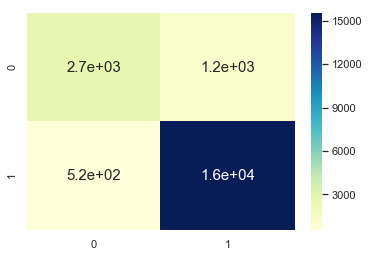

In [86]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

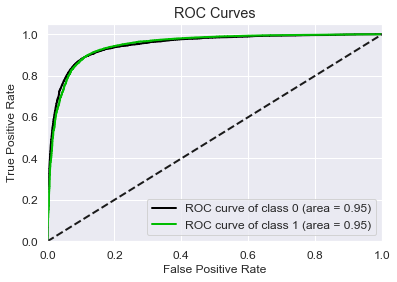

In [87]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

## [5.1.1.1] Feature importance for both positive and negative features.

In [88]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print ("\tTop {} Negative features\tTop {} Positive features".format(n, n))
    print ("\t------------------------\t------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [89]:
show_most_informative_features(count_vect, clf, n=25)

	Top 25 Negative features	Top 25 Positive features
	------------------------	------------------------
	-2.9149	not worth      		2.5542	great          
	-2.8461	worst          		2.5524	delicious      
	-2.6591	disappointed   		2.4402	best           
	-2.4865	not            		2.2753	good           
	-2.2571	terrible       		1.9595	love           
	-2.2387	awful          		1.9151	not disappointed
	-2.2276	disappointing  		1.8512	loves          
	-2.1375	horrible       		1.8305	perfect        
	-2.0825	return         		1.6548	excellent      
	-1.9704	disappointment 		1.5995	wonderful      
	-1.8265	not recommend  		1.4967	amazing        
	-1.8183	never buy      		1.4805	nice           
	-1.7459	stale          		1.4037	awesome        
	-1.7446	not good       		1.3049	happy          
	-1.7371	bland          		1.0636	yummy          
	-1.7106	product        		1.0508	keep           
	-1.7023	refund         		1.0495	day            
	-1.5955	not buy        		1.0195	little         
	-1.5591	disgus

# [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [90]:
openPickleFile("X_train_TFIDF_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 5000)
float64


In [91]:
openPickleFile("X_test_TFIDF_sparse")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 5000)
float64


**`RandomizedSearchCV`**

In [92]:
time_start = time.time()
#params should be passed as a dict not as list of dict.
tuned_parameters = {'alpha': [10**i for i in range(-7, 1)]
                    ,'tol': [10**i for i in range(-20, -1, 4)]
                   }                                             

clf = SGDClassifier()
#Using RandomizedSearchCV
RSCV_model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=-1,
                            random_state = 12, n_iter=5, verbose = True)
RSCV_model.fit(X_train, y_train)

print(RSCV_model.best_estimator_)
print(RSCV_model.score(X_test, y_test))

print ('CV for TFIDF for varying alpha and tolerance done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.6s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=1e-08, verbose=0, warm_start=False)
0.9575331044067235
CV for TFIDF for varying alpha and tolerance done! Time elapsed: 22.051170825958252 seconds


**`CalibratedClassifierCV`**

In [93]:
time_start = time.time()

#Using CalibratedClassifierCV
clf = SGDClassifier(tol=RSCV_model.best_params_['tol'], alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
#clf = SGDClassifier(tol=None, alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
model = CalibratedClassifierCV(base_estimator = clf, cv='prefit')
model.fit(X_test, y_test)
#model.fit(X_train, y_train)
print(model.calibrated_classifiers_[0])
print(model.score(X_test, y_test))

print ('CV for TFIDF using CalibratedClassifierCV done! Time elapsed: {} seconds'.format(time.time()-time_start))

0.92115
CV for TFIDF using CalibratedClassifierCV done! Time elapsed: 1.2456676959991455 seconds


In [94]:
#The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
clf.n_iter_ 

58

**AUC score**

In [95]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 85.935262%

The Test AUC score of SGD classifier is 85.203654%


**Precision, Recall and F1 score report**

In [96]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.84      0.74      0.79      3942
    class 1       0.94      0.97      0.95     16058

avg / total       0.92      0.92      0.92     20000



**Confusion matrix**

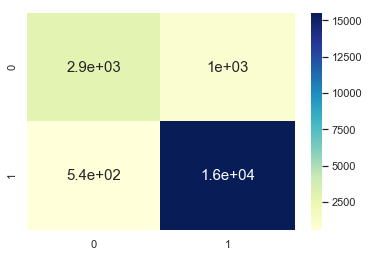

In [97]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

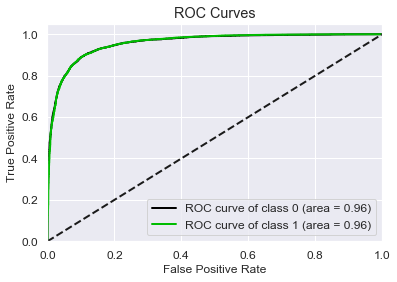

In [98]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

## [5.1.2.1] Feature importance for both positive and negative features.

In [99]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print ("\tTop {} Negative features\tTop {} Positive features".format(n, n))
    print ("\t------------------------\t------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [100]:
show_most_informative_features(tf_idf_vect, clf, n=25)

	Top 25 Negative features	Top 25 Positive features
	------------------------	------------------------
	-2.7276	worst          		2.7700	delicious      
	-2.6485	not worth      		2.4144	great          
	-2.3124	awful          		2.3916	best           
	-2.2359	disappointed   		2.0627	excellent      
	-2.1746	disappointing  		2.0230	not disappointed
	-2.1398	disappointment 		1.8807	loves          
	-2.1251	terrible       		1.7974	good           
	-1.9287	horrible       		1.7245	perfect        
	-1.9234	stale          		1.6220	wonderful      
	-1.7855	return         		1.6020	awesome        
	-1.6824	not good       		1.5129	love           
	-1.6770	not recommend  		1.4990	amazing        
	-1.6706	threw          		1.4157	nice           
	-1.6226	disgusting     		1.3479	happy          
	-1.6049	bland          		1.3094	pleased        
	-1.5708	worse          		1.2997	yummy          
	-1.5639	not buying     		1.1236	fantastic      
	-1.5534	tasteless      		1.1064	glad           
	-1.4966	sorry 

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [101]:
openPickleFile("X_train_AVG_W2V_vectors")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 50)
float64


In [102]:
openPickleFile("X_test_AVG_W2V_vectors")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 50)
float64


**`RandomizedSearchCV`**

In [103]:
time_start = time.time()
#params should be passed as a dict not as list of dict.
tuned_parameters = {'alpha': [10**i for i in range(-7, 1)]
                    ,'tol': [10**i for i in range(-20, -1, 4)]
                   }                                             

clf = SGDClassifier()
#Using RandomizedSearchCV
RSCV_model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=5, verbose = True)
RSCV_model.fit(X_train, y_train)

print(RSCV_model.best_estimator_)
print(RSCV_model.score(X_test, y_test))

print ('CV for AvgW2V for varying alpha and tolerance done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    4.5s finished


SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.0001, verbose=0, warm_start=False)
0.9089694612231068
CV for AvgW2V for varying alpha and tolerance done! Time elapsed: 5.1422507762908936 seconds


**`CalibratedClassifierCV`**

In [104]:
time_start = time.time()

#Using CalibratedClassifierCV
clf = SGDClassifier(tol=RSCV_model.best_params_['tol'], alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
#clf = SGDClassifier(tol=None, alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
model = CalibratedClassifierCV(base_estimator = clf, cv='prefit')
model.fit(X_test, y_test)
#model.fit(X_train, y_train)
print(model.calibrated_classifiers_[0])
print(model.score(X_test, y_test))

print ('CV for AvgW2V using CalibratedClassifierCV done! Time elapsed: {} seconds'.format(time.time()-time_start))

0.8713
CV for AvgW2V using CalibratedClassifierCV done! Time elapsed: 0.17254018783569336 seconds


In [105]:
#The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
clf.n_iter_ 

6

**AUC score**

In [106]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 76.612796%

The Test AUC score of SGD classifier is 74.988621%


**Precision, Recall and F1 score report**

In [107]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.73      0.55      0.63      3942
    class 1       0.90      0.95      0.92     16058

avg / total       0.86      0.87      0.86     20000



**Confusion matrix**

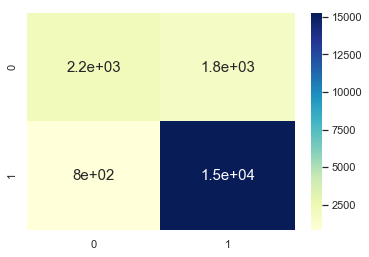

In [108]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

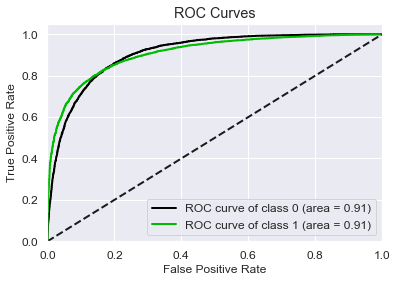

In [109]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [110]:
openPickleFile("X_train_TFIDF_AvgW2V")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 50)
float64


In [111]:
openPickleFile("X_test_TFIDF_AvgW2V")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 50)
float64


**`RandomizedSearchCV`**

In [112]:
time_start = time.time()
#params should be passed as a dict not as list of dict.
tuned_parameters = {'alpha': [10**i for i in range(-7, 1)]
                    ,'tol': [10**i for i in range(-20, -1, 4)]
                   }                                             

clf = SGDClassifier()
#Using RandomizedSearchCV
RSCV_model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=5, verbose = True)
RSCV_model.fit(X_train, y_train)

print(RSCV_model.best_estimator_)
print(RSCV_model.score(X_test, y_test))

print ('CV for TFIDF AvgW2V for varying alpha and tolerance done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    4.6s finished


SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.0001, verbose=0, warm_start=False)
0.8767831811358103
CV for TFIDF AvgW2V for varying alpha and tolerance done! Time elapsed: 5.2278032302856445 seconds


**`CalibratedClassifierCV`**

In [113]:
time_start = time.time()

#Using CalibratedClassifierCV
clf = SGDClassifier(tol=RSCV_model.best_params_['tol'], alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
#clf = SGDClassifier(tol=None, alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
model = CalibratedClassifierCV(base_estimator = clf, cv='prefit')
model.fit(X_test, y_test)
#model.fit(X_train, y_train)
print(model.calibrated_classifiers_[0])
print(model.score(X_test, y_test))

print ('CV for TFIDF AvgW2V using CalibratedClassifierCV done! Time elapsed: {} seconds'.format(time.time()-time_start))

0.8523
CV for TFIDF AvgW2V using CalibratedClassifierCV done! Time elapsed: 0.20245933532714844 seconds


In [114]:
#The actual number of iterations to reach the stopping criterion. For multiclass fits, it is the maximum over every binary fit.
clf.n_iter_ 

7

**AUC score**

In [115]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 72.024081%

The Test AUC score of SGD classifier is 69.996469%


**Precision, Recall and F1 score report**

In [116]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.69      0.45      0.54      3942
    class 1       0.88      0.95      0.91     16058

avg / total       0.84      0.85      0.84     20000



**Confusion matrix**

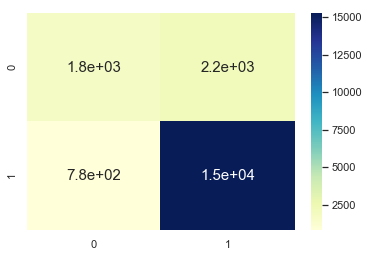

In [117]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

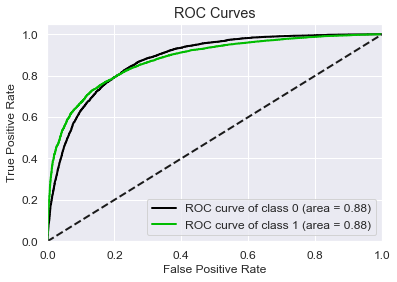

In [118]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

## [5.2] RBF SVM

In [101]:
#Taking 40k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 33712;
""", conn)

positive_reviews = display

In [102]:
#Taking 100k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 6288;
""", conn)

negative_reviews = display

In [103]:
#Combining postive reviews and negative reviews
final40k = []
final40k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final40k = final40k.sort_values('Time',ascending=True)

In [104]:
final40k_cleaned = final40k['cleaned_text'].values

In [105]:
labels40k = final40k['Score'].values
labels40k.dtype

dtype('int64')

In [106]:
#Splitting data to X_train and X_test based on time.
timeBasedSplit1(final40k_cleaned,labels40k,splits=4)

TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [   0    1    2 ... 7997 7998 7999] TEST: [ 8000  8001  8002 ... 15997 15998 15999]
TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 23997 23998 23999]
TRAIN: [    0     1     2 ... 23997 23998 23999] TEST: [24000 24001 24002 ... 31997 31998 31999]
TRAIN: [    0     1     2 ... 31997 31998 31999] TEST: [32000 32001 32002 ... 39997 39998 39999]


In [112]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train_2")
savePickleFile(y_train, "y_train_2")
savePickleFile(X_test, "X_test_2")
savePickleFile(y_test, "y_test_2")

# [5.2.1] Featurization

## [5.2.1.1] Bi-Grams and n-Grams.

In [189]:
openPickleFile("X_train_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(32000,)
object


In [190]:
openPickleFile("X_test_2")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(8000,)
object


**Vectorization of X_train**

In [191]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500) #in scikit-learn
bigram_fit = count_vect.fit(X_train) #1st fitting X_train for BoW bigrams.
final_bigram_counts_train = bigram_fit.transform(X_train)
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

the shape of out text BOW vectorizer  (32000, 500)
the number of unique words including both unigrams and bigrams  500


In [192]:
standardized_bigrams_train = MaxAbsScaler().fit_transform(final_bigram_counts_train)
standardized_bigrams_train

<32000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 582905 stored elements in Compressed Sparse Row format>

In [193]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_train, "X_train_bigram_sparse_2")

**Vectorization of X_test**

In [194]:
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts_test = bigram_fit.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (8000, 500)
the number of unique words including both unigrams and bigrams  500


In [195]:
standardized_bigrams_test = MaxAbsScaler().fit_transform(final_bigram_counts_test)
standardized_bigrams_test

<8000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 152055 stored elements in Compressed Sparse Row format>

In [196]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_test, "X_test_bigram_sparse_2")

## [5.2.1.2] TF-IDF

**Vectorization of X_train**

In [197]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_fit = tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_fit.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'although', 'always']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (32000, 500)
the number of unique words including both unigrams and bigrams  500


In [198]:
standardized_tfidf_train = MaxAbsScaler().fit_transform(final_tf_idf_train)
standardized_tfidf_train

<32000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 582905 stored elements in Compressed Sparse Row format>

In [199]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_train, "X_train_TFIDF_sparse_2")

**Vectorization of X_test**

In [200]:
final_tf_idf_test = tf_idf_fit.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (8000, 500)
the number of unique words including both unigrams and bigrams  500


In [201]:
standardized_tfidf_test = MaxAbsScaler().fit_transform(final_tf_idf_test)
standardized_tfidf_test

<8000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 152055 stored elements in Compressed Sparse Row format>

In [202]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_test, "X_test_TFIDF_sparse_2")

## [5.2.1.3] Word2Vec

**Vectorization of X_train**

In [203]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

In [204]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.7992005348205566), ('good', 0.7978200912475586), ('fantastic', 0.7959023118019104), ('wonderful', 0.789741575717926), ('awesome', 0.7773349285125732), ('amazing', 0.7307337522506714), ('terrific', 0.7210659384727478), ('perfect', 0.7043333649635315), ('incredible', 0.6769730448722839), ('fabulous', 0.6627506017684937)]
[('greatest', 0.7678932547569275), ('best', 0.7649414539337158), ('disgusting', 0.7522900104522705), ('nastiest', 0.745383620262146), ('closest', 0.7073326110839844), ('tastiest', 0.6994926333427429), ('reject', 0.6731454133987427), ('horrible', 0.6595240235328674), ('funniest', 0.6529374718666077), ('nicest', 0.6461841464042664)]


In [205]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11866
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


## [5.2.1.4] Converting text into vectors using Avg W2V, TFIDF-W2V

####  [5.2.1.4.1] Avg W2v

In [206]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 32000/32000 [00:58<00:00, 542.92it/s]


32000
50


**Standardization of AvgW2V of X_train**

In [207]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_train = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_train, "X_train_AVG_W2V_vectors_2")

**Vectorization of X_test**

In [208]:
# Training X_test using X_train model.
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

In [209]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 8000/8000 [00:15<00:00, 525.54it/s]


8000
50


**Standardization of W2V of X_test**

In [210]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_test = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_test, "X_test_AVG_W2V_vectors_2")

#### [5.2.1.4.2] TFIDF weighted W2v

**Training of X_train for TFIDF**

In [211]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [212]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

**Training of X_train for TFIDF AVGW2V**

In [213]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 32000/32000 [09:23<00:00, 56.78it/s]


**Standardization of TFIDF AvgW2V of X_train**

In [214]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_train = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_train, "X_train_TFIDF_AvgW2V_2")

**Training of X_test for TFIDF**

In [215]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [216]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

**Training of X_test for TFIDF AVGW2V**

In [217]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 8000/8000 [01:06<00:00, 119.60it/s]


**Standardization of TFIDF AvgW2V of X_train**

In [218]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_test = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_test, "X_test_TFIDF_AvgW2V_2")

### [5.2.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [131]:
openPickleFile("X_train_bigram_sparse_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(32000, 500)
float64


In [132]:
openPickleFile("X_test_bigram_sparse_2")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(8000, 500)
float64


In [133]:
openPickleFile("y_train_2")
y_train = temp
print(y_train.shape)
print(y_train.dtype)

(32000,)
int64


In [134]:
openPickleFile("y_test_2")
y_test = temp
print(y_test.shape)
print(y_test.dtype)

(8000,)
int64


**GridSearchCV**

In [109]:
y_train =y_train.astype(float)

In [110]:
y_train.dtype

dtype('float64')

In [111]:
time_start = time.time()

tuned_parameters = {'C': [10**i for i in range(-4,2,1)]
                   ,'gamma': [10**i for i in range(-4,4,2)]} #params should be passed as a dict not as list of dict.

#Using GridSearchCV
model =  GridSearchCV(SVC(probability=True, tol=1e-10), tuned_parameters, scoring = 'roc_auc', cv=2,
                             n_jobs=-1, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Bigrams for varying C and gamma done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 68.4min finished


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-10, verbose=False)
0.8817695695596388
CV for Bigrams for varying C and gamma done! Time elapsed: 5100.113379240036 seconds


In [112]:
savePickleFile(model, "BOW_GSCV")

In [145]:
openPickleFile("BOW_GSCV")
BOW_GSCV = temp

In [121]:
report(BOW_GSCV.cv_results_)

Model with rank: 1
Mean validation score: 0.876 (std: 0.003)
Parameters: {'gamma': 1, 'C': 1}

Model with rank: 2
Mean validation score: 0.872 (std: 0.004)
Parameters: {'gamma': 1, 'C': 0.001}

Model with rank: 2
Mean validation score: 0.872 (std: 0.004)
Parameters: {'gamma': 1, 'C': 0.01}

Model with rank: 2
Mean validation score: 0.872 (std: 0.004)
Parameters: {'gamma': 1, 'C': 0.1}



**Hyperparameter heat map**

In [122]:
HP_heatmap = [[BOW_GSCV.cv_results_['params'][:][i]['gamma'], BOW_GSCV.cv_results_['params'][:][i]['C'],
              BOW_GSCV.cv_results_['mean_test_score'][i]] for i in range(24)]

In [123]:
HP_heatmap = pd.DataFrame(HP_heatmap, columns=('gamma', 'C', 'mean_test_score'), dtype=np.float64)

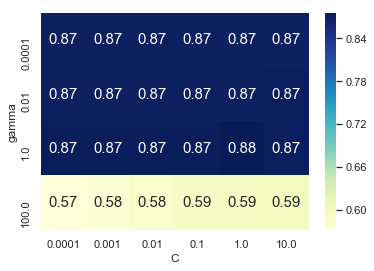

In [124]:
import seaborn as sns; sns.set()

HP_heatmap = HP_heatmap.pivot('gamma', 'C', 'mean_test_score')

#sns.set(font_scale=1.4)#for label size
sns.heatmap(HP_heatmap, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection .

**AUC score**

In [135]:
from sklearn.metrics import roc_auc_score
y_train_pred = BOW_GSCV.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = BOW_GSCV.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 79.486911%

The Test AUC score of SGD classifier is 65.650677%


**Precision, Recall and F1 score report**

In [137]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.80      0.33      0.47      1571
    class 1       0.86      0.98      0.91      6429

avg / total       0.85      0.85      0.83      8000



**Confusion matrix**

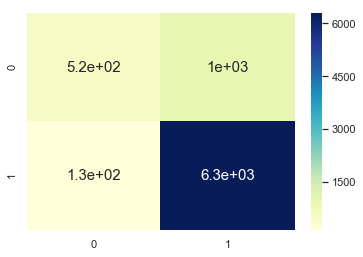

In [138]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

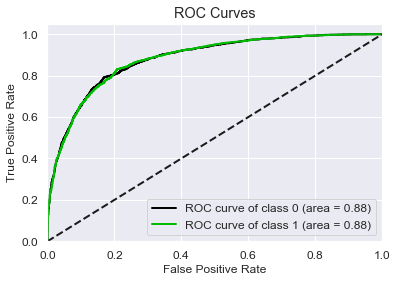

In [139]:
import scikitplot as skplt

predicted_probas = BOW_GSCV.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.2.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [140]:
openPickleFile("X_train_TFIDF_sparse_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(32000, 500)
float64


In [141]:
openPickleFile("X_test_TFIDF_sparse_2")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(8000, 500)
float64


**`GridSearchCV`**

In [121]:
time_start = time.time()

tuned_parameters = {'C': [10**i for i in range(-4,2,1)]
                   ,'gamma': [10**i for i in range(-4,4,2)]} #params should be passed as a dict not as list of dict.

#Using RandomizedSearchCV
model =  GridSearchCV(SVC(probability=True, tol=1e-10), tuned_parameters, scoring = 'roc_auc', cv=2,
                             n_jobs=-1, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for TFIDF for varying C and gamma done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 76.0min finished


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-10, verbose=False)
0.898854886440628
CV for TFIDF for varying C and gamma done! Time elapsed: 9165.674159526825 seconds


In [122]:
savePickleFile(model, "TFIDF_GSCV")

In [146]:
openPickleFile("TFIDF_GSCV")
TFIDF_GSCV = temp

In [147]:
report(TFIDF_GSCV.cv_results_)

Model with rank: 1
Mean validation score: 0.889 (std: 0.003)
Parameters: {'gamma': 1, 'C': 10}

Model with rank: 2
Mean validation score: 0.886 (std: 0.004)
Parameters: {'gamma': 1, 'C': 1}

Model with rank: 3
Mean validation score: 0.882 (std: 0.005)
Parameters: {'gamma': 1, 'C': 0.001}

Model with rank: 3
Mean validation score: 0.882 (std: 0.005)
Parameters: {'gamma': 1, 'C': 0.01}



**`CalibratedClassifierCV`**

In [148]:
time_start = time.time()

#Using CalibratedClassifierCV
clf = SVC(probability=True, tol=1e-10, C=TFIDF_GSCV.best_params_['C'], gamma=TFIDF_GSCV.best_params_['gamma']).fit(X_train, y_train)
#clf = SGDClassifier(tol=None, alpha=RSCV_model.best_params_['alpha']).fit(X_train, y_train)
TFIDF_CCCV = CalibratedClassifierCV(base_estimator = clf, cv='prefit')
TFIDF_CCCV.fit(X_test, y_test)
#model.fit(X_train, y_train)
print(TFIDF_CCCV.calibrated_classifiers_[0])
print(TFIDF_CCCV.score(X_test, y_test))

print ('CV for Bigrams using CalibratedClassifierCV done! Time elapsed: {} seconds'.format(time.time()-time_start))

0.86925
CV for Bigrams using CalibratedClassifierCV done! Time elapsed: 4709.2950603961945 seconds


**Hyperparameter heat map**

In [149]:
HP_heatmap = [[TFIDF_GSCV.cv_results_['params'][:][i]['gamma'], TFIDF_GSCV.cv_results_['params'][:][i]['C'],
              TFIDF_GSCV.cv_results_['mean_test_score'][i]] for i in range(len(TFIDF_GSCV.cv_results_['params']))]

In [150]:
HP_heatmap = pd.DataFrame(HP_heatmap, columns=('gamma', 'C', 'mean_test_score'), dtype=np.float64)

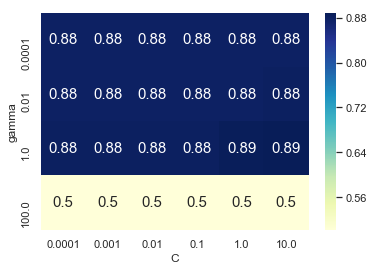

In [151]:
import seaborn as sns; sns.set()

HP_heatmap = HP_heatmap.pivot('gamma', 'C', 'mean_test_score')

#sns.set(font_scale=1.4)#for label size
sns.heatmap(HP_heatmap, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection .

**AUC score**

In [152]:
from sklearn.metrics import roc_auc_score
y_train_pred = TFIDF_CCCV.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = TFIDF_CCCV.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 99.849768%

The Test AUC score of SGD classifier is 73.827785%


**Precision, Recall and F1 score report**

In [153]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.74      0.52      0.61      1571
    class 1       0.89      0.95      0.92      6429

avg / total       0.86      0.87      0.86      8000



**Confusion matrix**

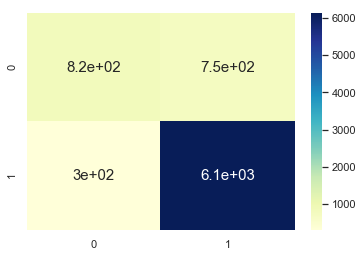

In [154]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

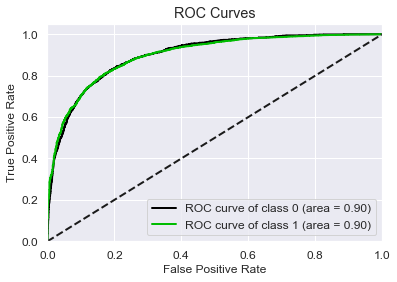

In [155]:
import scikitplot as skplt

predicted_probas = TFIDF_CCCV.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.2.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [241]:
openPickleFile("X_train_AVG_W2V_vectors_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(32000, 50)
float64


In [242]:
openPickleFile("X_test_AVG_W2V_vectors_2")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(8000, 50)
float64


**`GridSearchCV`**

In [132]:
time_start = time.time()

tuned_parameters = {'C': [10**i for i in range(-4,2,1)]
                   ,'gamma': [10**i for i in range(-4,4,2)]} #params should be passed as a dict not as list of dict.

#Using RandomizedSearchCV
model =  GridSearchCV(SVC(probability=True, tol=1e-10), tuned_parameters, scoring = 'roc_auc', cv=2,
                            n_jobs=6, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Avg W2V in range(10e-4, 10e+4) done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed: 87.8min finished


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-10, verbose=False)
0.892299513295054
CV for Avg W2V in range(10e-4, 10e+4) done! Time elapsed: 5498.708573818207 seconds


In [133]:
savePickleFile(model, "Avg_W2V_GSCV")

In [243]:
openPickleFile("Avg_W2V_GSCV")
Avg_W2V_GSCV = temp

In [244]:
report(Avg_W2V_GSCV.cv_results_)

Model with rank: 1
Mean validation score: 0.885 (std: 0.001)
Parameters: {'gamma': 0.01, 'C': 1}

Model with rank: 2
Mean validation score: 0.882 (std: 0.001)
Parameters: {'gamma': 0.01, 'C': 0.0001}

Model with rank: 2
Mean validation score: 0.882 (std: 0.001)
Parameters: {'gamma': 0.01, 'C': 0.001}

Model with rank: 2
Mean validation score: 0.882 (std: 0.001)
Parameters: {'gamma': 0.01, 'C': 0.01}

Model with rank: 2
Mean validation score: 0.882 (std: 0.001)
Parameters: {'gamma': 0.01, 'C': 0.1}



**Hyperparameter heat map**

In [245]:
HP_heatmap = [[Avg_W2V_GSCV.cv_results_['params'][:][i]['gamma'], Avg_W2V_GSCV.cv_results_['params'][:][i]['C'],
              Avg_W2V_GSCV.cv_results_['mean_test_score'][i]] for i in range(len(Avg_W2V_GSCV.cv_results_['mean_test_score']))]

In [246]:
HP_heatmap = pd.DataFrame(HP_heatmap, columns=('gamma', 'C', 'mean_test_score'), dtype=np.float64)

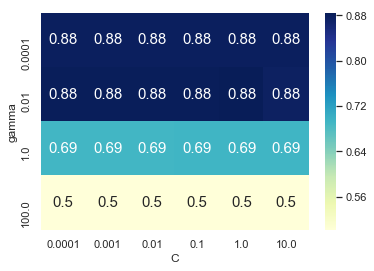

In [247]:
import seaborn as sns; sns.set()

HP_heatmap = HP_heatmap.pivot('gamma', 'C', 'mean_test_score')

#sns.set(font_scale=1.4)#for label size
sns.heatmap(HP_heatmap, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection .

**AUC score**

In [248]:
from sklearn.metrics import roc_auc_score
y_train_pred = Avg_W2V_GSCV.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = Avg_W2V_GSCV.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 67.734649%

The Test AUC score of SGD classifier is 63.847794%


**Precision, Recall and F1 score report**

In [249]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.81      0.29      0.43      1571
    class 1       0.85      0.98      0.91      6429

avg / total       0.84      0.85      0.82      8000



**Confusion matrix**

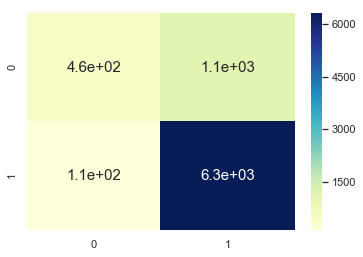

In [250]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

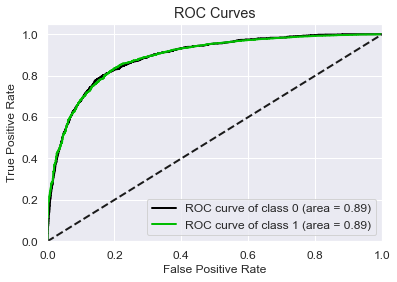

In [251]:
import scikitplot as skplt

predicted_probas = Avg_W2V_GSCV.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.2.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [252]:
openPickleFile("X_train_TFIDF_AvgW2V_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(32000, 50)
float64


In [253]:
openPickleFile("X_test_TFIDF_AvgW2V_2")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(8000, 50)
float64


**GridSearchCV**

In [142]:
time_start = time.time()

tuned_parameters = {'C': [10**i for i in range(-4,2,1)]
                   ,'gamma': [10**i for i in range(-4,4,2)]} #params should be passed as a dict not as list of dict.

#Using RandomizedSearchCV
model =  GridSearchCV(SVC(probability=True, tol=1e-10), tuned_parameters, scoring = 'roc_auc', cv=2,
                             n_jobs=-1, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for TFIDF Avg W2V for varying C and gamma done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 58.2min finished


SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=1e-10, verbose=False)
0.8676756509605632
CV for TFIDF Avg W2V for varying C and gamma done! Time elapsed: 3747.216131210327 seconds


In [143]:
savePickleFile(model, "TFIDF_Avg_W2VF_GSCV")

In [254]:
openPickleFile("TFIDF_Avg_W2VF_GSCV")
TFIDF_Avg_W2VF_GSCV = temp

In [255]:
report(TFIDF_Avg_W2VF_GSCV.cv_results_)

Model with rank: 1
Mean validation score: 0.863 (std: 0.005)
Parameters: {'gamma': 0.01, 'C': 1}

Model with rank: 2
Mean validation score: 0.861 (std: 0.003)
Parameters: {'gamma': 0.01, 'C': 0.001}

Model with rank: 2
Mean validation score: 0.861 (std: 0.003)
Parameters: {'gamma': 0.01, 'C': 0.01}

Model with rank: 2
Mean validation score: 0.861 (std: 0.003)
Parameters: {'gamma': 0.01, 'C': 0.1}



**Hyperparameter heat map**

In [256]:
HP_heatmap = [[TFIDF_Avg_W2VF_GSCV.cv_results_['params'][:][i]['gamma'], TFIDF_Avg_W2VF_GSCV.cv_results_['params'][:][i]['C'],
             TFIDF_Avg_W2VF_GSCV.cv_results_['mean_test_score'][i]] for i in range(len(TFIDF_Avg_W2VF_GSCV.cv_results_['params']))]

In [257]:
HP_heatmap = pd.DataFrame(HP_heatmap, columns=('gamma', 'C', 'mean_test_score'), dtype=np.float64)

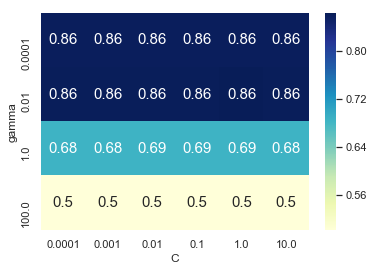

In [258]:
import seaborn as sns; sns.set()

HP_heatmap = HP_heatmap.pivot('gamma', 'C', 'mean_test_score')

#sns.set(font_scale=1.4)#for label size
sns.heatmap(HP_heatmap, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection .

**AUC score**

In [259]:
from sklearn.metrics import roc_auc_score
y_train_pred = TFIDF_Avg_W2VF_GSCV.predict(X_train)

optimal_cv_result = roc_auc_score(y_train, y_train_pred)
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of SGD classifier is %f%%' % (acc))

# evaluate accuracy
pred = TFIDF_Avg_W2VF_GSCV.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of SGD classifier is %f%%' % (acc))


The CV AUC score of SGD classifier is 62.433572%

The Test AUC score of SGD classifier is 59.307082%


**Precision, Recall and F1 score report**

In [260]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.80      0.20      0.32      1571
    class 1       0.83      0.99      0.90      6429

avg / total       0.83      0.83      0.79      8000



**Confusion matrix**

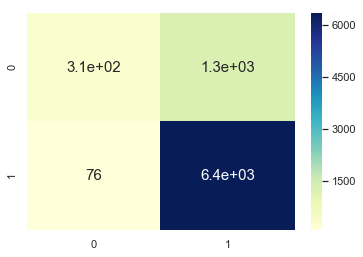

In [261]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

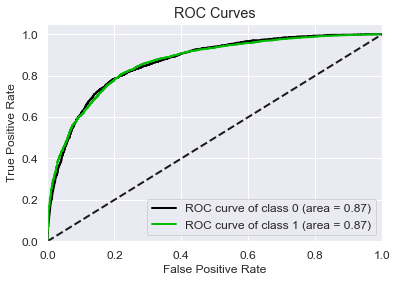

In [262]:
import scikitplot as skplt

predicted_probas = TFIDF_Avg_W2VF_GSCV.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

# [6] Conclusions

In [265]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW(Bigrams)", "SGDc(linear)", "tol=1e-20", 0.95])
x.add_row(["TFIDF", "SGDc(linear)", "tol=1e-20", 0.96])
x.add_row(["Avg W2V", "SGDc(linear)", "tol=1e-20", 0.91])
x.add_row(["TFIDF Avg W2V", "SGDc(linear)", "tol=1e-20", 0.88])
x.add_row(["BOW(Bigrams)", "SVC(RBF)", "C = 10", 0.88])
x.add_row(["TFIDF", "SVC(RBF)", "C = 1000", 0.90])
x.add_row(["Avg W2V", "SVC(RBF)", "C = 0.1", 0.89])
x.add_row(["TFIDF Avg W2V", "SVC(RBF)", "C = 10", 0.87])

print(x)

+---------------+--------------+----------------+------+
|   Vectorizer  |    Model     | Hyperparameter | AUC  |
+---------------+--------------+----------------+------+
|  BOW(Bigrams) | SGDc(linear) |   tol=1e-20    | 0.95 |
|     TFIDF     | SGDc(linear) |   tol=1e-20    | 0.96 |
|    Avg W2V    | SGDc(linear) |   tol=1e-20    | 0.91 |
| TFIDF Avg W2V | SGDc(linear) |   tol=1e-20    | 0.88 |
|  BOW(Bigrams) |   SVC(RBF)   |     C = 10     | 0.88 |
|     TFIDF     |   SVC(RBF)   |    C = 1000    | 0.9  |
|    Avg W2V    |   SVC(RBF)   |    C = 0.1     | 0.89 |
| TFIDF Avg W2V |   SVC(RBF)   |     C = 10     | 0.87 |
+---------------+--------------+----------------+------+
